In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display


In [2]:
deb_models = ['std', 'stf', 'stx', 'abj']
parameter_cols = ['p_Am', 'kap', 'v', 'p_M', 'E_G', 'h_a', 'E_Hb', 'E_Hj', 'E_Hx', 'E_Hp']
taxonomy_cols = ['family', 'order', 'class', 'phylum']
ecocode_cols = ['climate', 'ecozone', 'habitat', 'embryo', 'migrate', 'food', 'gender', 'reprod']
age_data_cols = ['ab', 'ah', 'aj', 'ax', 'ap', 'am']
time_since_birth_data_cols = ['tg', 'tb', 'tj', 'tx', 'tp']
weight_data_cols = ['Wwb', 'Wwj', 'Wwx', 'Wwp', 'Wwi']
length_data_cols = ['Lb', 'Lj', 'Lx', 'Lp', 'Li']
other_cols = ['d_V', 'Ri', 'T_typical', 't_0', 'model']

In [3]:
ERROR_VARS = ['MRE', 'SMSE']
BIJECTION_DATA_VARS = ['ab', 'ap', 'am', 'd_V', 'Wwb', 'Wwzj', 'Wwp', 'Wwi', 'R_i']

In [4]:
datasets_folder = '../data/'

# Helper functions

In [5]:
def print_missing_values_per_column(df, columns=None, percentage=True):
    if columns is None:
        columns = df.columns
    for c in columns:
        n_missing = pd.isna(df[c]).sum()
        if n_missing:
            if percentage:
                print(f"{n_missing/len(df)*100:.1f} % missing values in column {c}")
            else:
                print(f"{n_missing} missing values in column {c}")

In [45]:
def plot_missing_values_per_column(df):
    if 'stx' not in df['model'].unique():
        df = df.drop(columns=['ax', 'tx', 'Wwx', 'Lx', 'E_Hx'])
    if 'abj' not in df['model'].unique():
        df = df.drop(columns=['aj', 'tj', 'Wwj', 'Lj', 'E_Hj'])
    df = df.drop(columns=ecocode_cols)
    missing_df = pd.Series(index=df.columns, name='n_missing')
    for col in df.columns:
        missing_df.loc[col] = pd.isna(df[col]).sum() / len(df) * 100
    missing_df = missing_df[missing_df > 0]
    missing_df
    fig, ax = plt.subplots(1,1, figsize=(10, 6))
    sns.barplot(missing_df, ax=ax)
    ax.bar_label(ax.containers[0], fmt=lambda v: f"{v:.1f}", fontsize=8)
    ax.set_ylabel('Percentage of species with a missing value')
    ax.set_ylim([0, 100])

def plot_missing_values_per_mat_level(df, ax=None):
    missing_df = pd.DataFrame(index=['birth', 'puberty', 'adult'], columns=['weight or length', 'age or time since birth', 'both'])
    if 'stx' in df['model'].unique():
        missing_df.loc['weaning', 'weight or length'] = ( pd.isna(df[['Wwx', 'Lx']]).all(axis=1).sum() ) 
        missing_df.loc['weaning', 'age or time since birth'] = ( pd.isna(df[['ax', 'tx']]).all(axis=1).sum() ) 
        missing_df.loc['weaning', 'both'] = ( pd.isna(df[['ax', 'tx', 'Wwx', 'Lx']]).all(axis=1).sum() ) 

    if 'abj' in df['model'].unique():
        missing_df.loc['metamorphosis', 'age or time since birth'] = ( pd.isna(df[['aj', 'tj']]).all(axis=1).sum() ) 
        missing_df.loc['metamorphosis', 'weight or length'] = ( pd.isna(df[['Wwj', 'Lj']]).all(axis=1).sum() ) 
        missing_df.loc['metamorphosis', 'both'] = ( pd.isna(df[['Wwj', 'Lj', 'aj', 'tj']]).all(axis=1).sum() ) 
        
    missing_df.loc['birth', 'weight or length'] = ( pd.isna(df[['Wwb', 'Lb']]).all(axis=1).sum() ) 
    missing_df.loc['puberty', 'weight or length'] = ( pd.isna(df[['Wwp', 'Lp']]).all(axis=1).sum() ) 
    missing_df.loc['adult', 'weight or length'] = ( pd.isna(df[['Wwi', 'Li']]).all(axis=1).sum() ) 

    missing_df.loc['birth', 'age or time since birth'] = ( pd.isna(df[['ab', 'tb', 'tg']]).all(axis=1).sum() ) 
    missing_df.loc['puberty', 'age or time since birth'] = ( pd.isna(df[['ap', 'tp']]).all(axis=1).sum() ) 
    missing_df.loc['adult', 'age or time since birth'] = ( pd.isna(df[['am']]).all(axis=1).sum() ) 

    missing_df.loc['birth', 'both'] = ( pd.isna(df[['Wwb', 'Lb', 'ab', 'tb', 'tg']]).all(axis=1).sum() ) 
    missing_df.loc['puberty', 'both'] = ( pd.isna(df[['Wwp', 'Lp', 'ap', 'tp']]).all(axis=1).sum() ) 
    missing_df.loc['adult', 'both'] = ( pd.isna(df[['Wwi', 'Li', 'am']]).all(axis=1).sum() ) 
    
    mis_df = (missing_df / len(df) * 100).stack().reset_index() 
    mis_df.columns = ['mat_level', 'data_type', 'percent_missing']
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(10, 6))
    sns.barplot(data=mis_df, x='mat_level', y='percent_missing', hue='data_type', ax=ax)
    ax.bar_label(ax.containers[0], fmt=lambda v: f"{v:.1f}", fontsize=10)
    ax.bar_label(ax.containers[1], fmt=lambda v: f"{v:.1f}", fontsize=10)
    ax.bar_label(ax.containers[2], fmt=lambda v: f"{v:.1f}", fontsize=10)
    ax.set_xlabel('Maturity level')
    ax.set_ylabel('Percentage of species with no data')
    ax.set_ylim([0, 100])

# Missing values in raw data

In [7]:
raw_data = pd.read_csv(f"{datasets_folder}/raw/dataset_matlab.csv", index_col=0)
raw_data.dropna(how='all', inplace=True)
raw_data.index.name = 'species'
raw_data

,p_Am,kap,v,p_M,E_G,h_a,E_Hb,E_Hj,E_Hx,E_Hp,...,Lb,Lj,Lx,Lp,Li,d_V,Ri,T_typical,t_0,model
species,,,,,,,,,,,,,,,,,,,,,
Abatus_cordatus,41.918449,0.77712,0.027220,13.8449,2393.8237,5.047000e-06,0.487600,6.941000,NaN,1403.000,...,NaN,0.276,NaN,1.90,8.0,0.09,NaN,278.15,NaN,abj
Abbottina_rivularis,75.309251,0.97055,0.020221,23.8370,5215.8135,3.547000e-07,0.045900,0.069550,NaN,89.340,...,NaN,NaN,NaN,4.50,18.9,0.20,7.772727,291.15,149.8737,abj
Ablennes_hians,201.398502,0.99640,0.022797,17.9765,5237.1062,1.614000e-09,0.003540,0.029360,NaN,1083.000,...,NaN,NaN,NaN,47.40,140.0,0.20,73.373736,301.05,NaN,abj
Abra_segmentum,8.266674,0.93000,0.020926,25.2041,2349.9631,7.505000e-07,0.000601,0.011460,NaN,10.940,...,NaN,NaN,NaN,0.90,1.9,0.09,48.959720,288.15,NaN,abj
Abralia_trigonura,109.484284,0.98081,0.009515,1009.8108,5492.3580,1.526000e-10,0.001511,2.628000,NaN,14.090,...,0.08,NaN,NaN,1.40,4.0,0.21,NaN,291.15,NaN,abj
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zosterisessor_ophiocephalus,90.838193,0.97755,0.020245,17.1271,5231.3551,1.513000e-07,0.003958,NaN,NaN,1577.000,...,NaN,NaN,NaN,12.65,29.9,0.20,100.486494,290.25,NaN,std
Zosterops_lateralis,872.827510,0.97558,0.035919,617.3516,7324.4923,2.674000e-12,76.790000,NaN,456.8,1199.000,...,NaN,NaN,NaN,NaN,NaN,0.28,0.067583,314.75,NaN,std
Zosterops_virens,940.612495,0.99060,0.031028,734.2559,7319.8077,3.005000e-12,21.060000,NaN,101.4,294.800,...,NaN,NaN,NaN,NaN,NaN,0.28,0.045055,314.75,NaN,std


In [8]:
raw_data.dtypes

p_Am         float64
kap          float64
v            float64
p_M          float64
E_G          float64
h_a          float64
E_Hb         float64
E_Hj         float64
E_Hx         float64
E_Hp         float64
family        object
order         object
class         object
phylum        object
climate       object
ecozone       object
habitat       object
embryo        object
migrate       object
food          object
gender        object
reprod        object
ab           float64
ah           float64
aj           float64
ax           float64
ap           float64
am           float64
tg           float64
tb           float64
tj           float64
tx           float64
tp           float64
Wwb          float64
Wwj          float64
Wwx          float64
Wwp          float64
Wwi          float64
Lb           float64
Lj           float64
Lx           float64
Lp           float64
Li           float64
d_V          float64
Ri           float64
T_typical    float64
t_0          float64
model        

Text(0.5, 1.0, 'Distribution of DEB models')

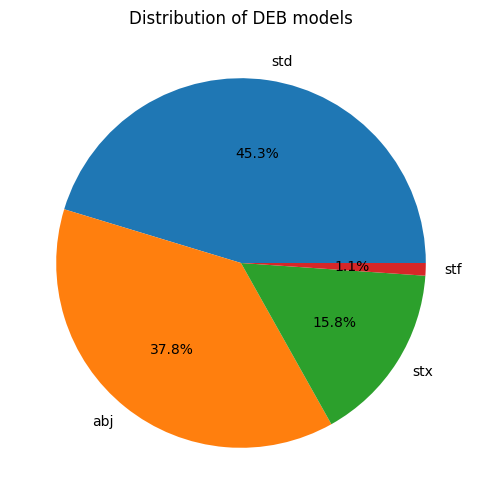

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.pie(raw_data['model'].value_counts().values, labels=raw_data['model'].value_counts().index.values, autopct='%1.1f%%')
ax.set_title('Distribution of DEB models')

## Missing values for std species

In [51]:
raw_std_data = raw_data[raw_data['model'] == 'std'].copy()
#raw_std_data.drop(columns=['ax', 'aj', 'tx', 'tj', 'Wwx', 'Wwj', 'Lx', 'Lj', 'E_Hx', 'E_Hj'], inplace=True)
raw_std_data

,p_Am,kap,v,p_M,E_G,h_a,E_Hb,E_Hj,E_Hx,E_Hp,...,Lb,Lj,Lx,Lp,Li,d_V,Ri,T_typical,t_0,model
species,,,,,,,,,,,,,,,,,,,,,
Abroscopus_superciliaris,663.006069,0.95822,0.034790,533.0640,7316.5423,4.147000e-12,96.030000,NaN,631.4,1472.0,...,NaN,NaN,NaN,NaN,NaN,0.28,0.072088,314.75,NaN,std
Acanthis_flammea,1294.709603,0.92908,0.037653,907.6351,7320.7246,2.215000e-12,211.900000,NaN,1348.0,3305.0,...,NaN,NaN,NaN,NaN,NaN,0.28,0.225276,314.75,NaN,std
Acanthis_hornemanni,709.593021,0.95793,0.047468,432.1025,7335.3504,8.946000e-13,197.800000,NaN,1236.0,3203.0,...,NaN,NaN,NaN,NaN,NaN,0.28,0.101374,314.75,NaN,std
Acanthisitta_chloris,3037.650231,0.98132,0.026069,4238.5777,7324.1141,1.013000e-14,69.760000,NaN,NaN,2759.0,...,NaN,NaN,NaN,NaN,NaN,0.28,0.127982,314.15,0.005925,std
Acanthiza_chrysorrhoa,1535.986331,0.87780,0.024775,935.9217,7323.4764,1.093000e-11,644.900000,NaN,3886.0,8467.0,...,NaN,NaN,NaN,NaN,NaN,0.28,0.157693,314.75,NaN,std
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zonotrichia_querula,1476.816557,0.97417,0.041453,834.8830,7333.1130,3.237000e-12,188.800000,NaN,817.4,2151.0,...,NaN,NaN,NaN,NaN,NaN,0.28,0.090110,314.75,NaN,std
Zootoca_vivipara,516.242968,0.72515,0.023765,344.4866,7837.0592,1.533000e-07,226.400000,NaN,NaN,6375.0,...,2.1,NaN,NaN,5.00,7.0,0.30,0.018635,286.85,NaN,std
Zosterisessor_ophiocephalus,90.838193,0.97755,0.020245,17.1271,5231.3551,1.513000e-07,0.003958,NaN,NaN,1577.0,...,NaN,NaN,NaN,12.65,29.9,0.20,100.486494,290.25,NaN,std


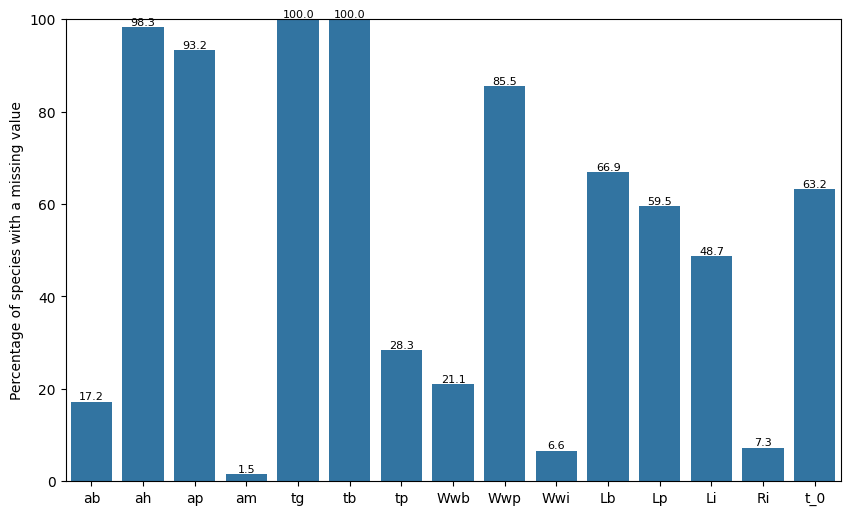

In [52]:
plot_missing_values_per_column(raw_std_data)

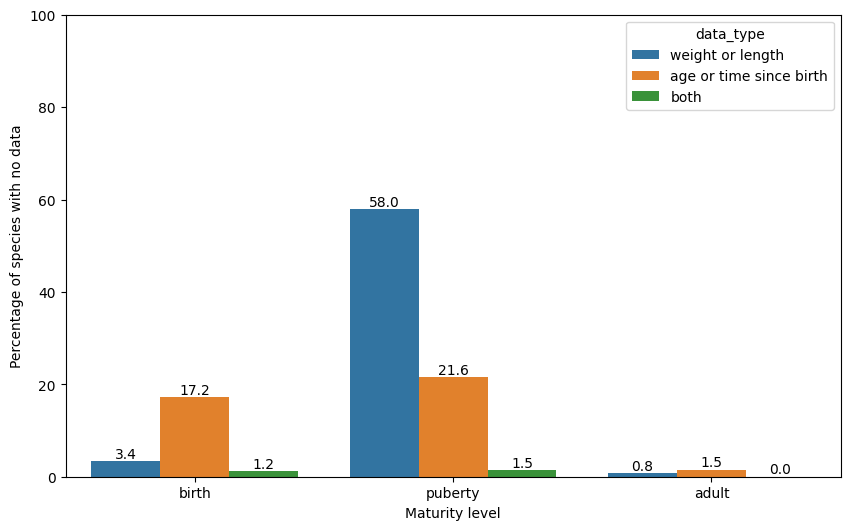

In [53]:
plot_missing_values_per_mat_level(raw_std_data)

## Missing values for abj species

In [54]:
raw_abj_data = raw_data[raw_data['model'] == 'abj'].copy()
raw_abj_data

,p_Am,kap,v,p_M,E_G,h_a,E_Hb,E_Hj,E_Hx,E_Hp,...,Lb,Lj,Lx,Lp,Li,d_V,Ri,T_typical,t_0,model
species,,,,,,,,,,,,,,,,,,,,,
Abatus_cordatus,41.918449,0.77712,0.027220,13.8449,2393.8237,5.047000e-06,0.487600,6.941000,NaN,1403.000,...,NaN,0.276,NaN,1.90,8.0,0.09,NaN,278.15,NaN,abj
Abbottina_rivularis,75.309251,0.97055,0.020221,23.8370,5215.8135,3.547000e-07,0.045900,0.069550,NaN,89.340,...,NaN,NaN,NaN,4.50,18.9,0.20,7.772727,291.15,149.8737,abj
Ablennes_hians,201.398502,0.99640,0.022797,17.9765,5237.1062,1.614000e-09,0.003540,0.029360,NaN,1083.000,...,NaN,NaN,NaN,47.40,140.0,0.20,73.373736,301.05,NaN,abj
Abra_segmentum,8.266674,0.93000,0.020926,25.2041,2349.9631,7.505000e-07,0.000601,0.011460,NaN,10.940,...,NaN,NaN,NaN,0.90,1.9,0.09,48.959720,288.15,NaN,abj
Abralia_trigonura,109.484284,0.98081,0.009515,1009.8108,5492.3580,1.526000e-10,0.001511,2.628000,NaN,14.090,...,0.08,NaN,NaN,1.40,4.0,0.21,NaN,291.15,NaN,abj
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zingel_asper,29.887197,0.73146,0.022384,93.5923,5234.1312,8.275000e-09,0.797400,6671.000000,NaN,6672.000,...,NaN,NaN,NaN,7.00,22.0,0.20,375.650042,289.15,NaN,abj
Zoarces_americanus,792.253004,0.68378,0.025261,57.8286,5216.6873,2.070000e-07,19.250000,19.380000,NaN,50750.000,...,NaN,NaN,NaN,28.80,110.0,0.20,1.402749,276.15,NaN,abj
Zoarces_elongatus,20.783776,0.99909,0.023702,19.8422,5216.6846,3.140000e-08,0.004859,3.046000,NaN,117.000,...,NaN,NaN,NaN,19.06,56.0,0.20,0.211586,281.15,NaN,abj


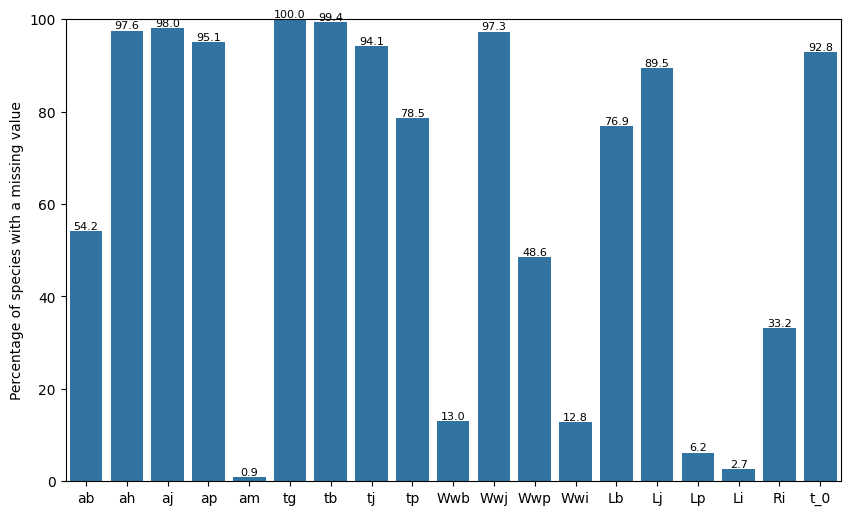

In [55]:
plot_missing_values_per_column(raw_abj_data)

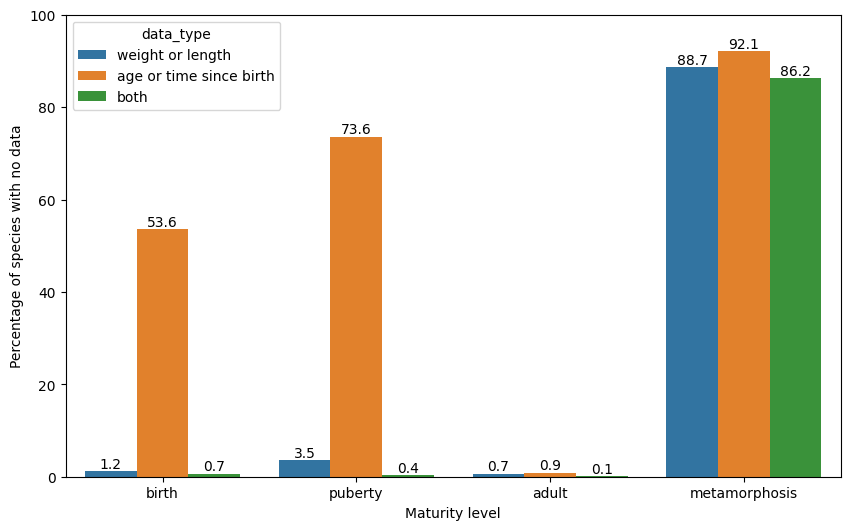

In [56]:
plot_missing_values_per_mat_level(raw_abj_data)

## Missing values in stx species

In [57]:
raw_stx_data = raw_data[raw_data['model'] == 'stx'].copy()
raw_stx_data

,p_Am,kap,v,p_M,E_G,h_a,E_Hb,E_Hj,E_Hx,E_Hp,...,Lb,Lj,Lx,Lp,Li,d_V,Ri,T_typical,t_0,model
species,,,,,,,,,,,,,,,,,,,,,
Acinonyx_jubatus,1738.396940,0.98748,0.077145,73.9628,7837.3620,1.394000e-11,1.485000e+04,NaN,3.650000e+05,3.556000e+06,...,NaN,NaN,NaN,NaN,NaN,0.3,0.030292,312.15,5.226190e+01,stx
Acomys_cahirinus,2400.992637,0.93589,0.045779,1328.0526,7829.6773,7.070000e-22,1.102000e+03,NaN,7.985000e+03,5.263000e+04,...,NaN,NaN,NaN,NaN,NaN,0.3,0.133829,310.65,2.090250e+01,stx
Acrobates_pygmaeus,412.338561,0.99859,0.023186,267.2880,7844.3693,2.347000e-15,6.466000e-02,NaN,8.507000e+01,3.653000e+02,...,NaN,NaN,NaN,NaN,NaN,0.3,0.060505,307.85,5.891820e+01,stx
Acrocodia_indica,12083.060435,0.96038,0.076562,442.1893,7838.4719,1.798000e-16,4.241000e+05,NaN,2.198000e+07,1.550000e+08,...,NaN,NaN,NaN,NaN,NaN,0.3,0.006013,309.95,3.311668e+02,stx
Addax_nasomaculatus,1947.746927,0.72417,0.181750,42.5828,7829.2536,3.892000e-20,8.431000e+06,NaN,9.192000e+07,2.755000e+08,...,NaN,NaN,NaN,NaN,NaN,0.3,0.013284,311.15,2.339221e+02,stx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zalophus_wollebaeki,2089.716672,0.86534,0.065480,49.3738,7387.1473,1.447000e-12,1.859000e+06,NaN,3.379000e+07,1.278000e+08,...,NaN,NaN,NaN,NaN,NaN,0.3,0.012227,310.15,2.272490e+02,stx
Zapus_hudsonius,1165.088401,0.97901,0.029403,662.0426,7853.5372,5.076000e-10,4.259000e+01,NaN,9.317000e+02,2.908000e+03,...,NaN,NaN,NaN,NaN,NaN,0.3,0.109774,307.15,4.595000e+00,stx
Zelotomys_woosnami,4586.733148,0.96474,0.070670,2508.5062,7842.4142,2.717000e-10,3.631000e+02,NaN,2.994000e+04,1.471000e+05,...,NaN,NaN,NaN,NaN,NaN,0.3,0.104075,309.75,2.393420e+01,stx


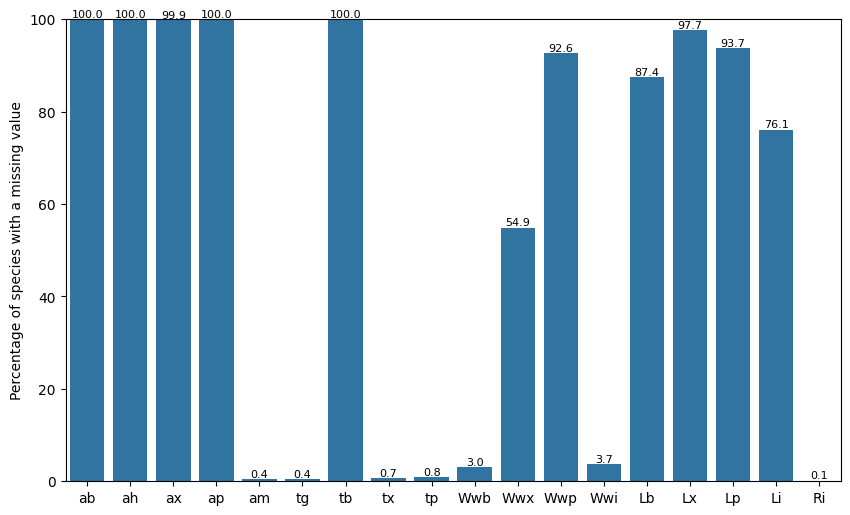

In [58]:
plot_missing_values_per_column(raw_stx_data)

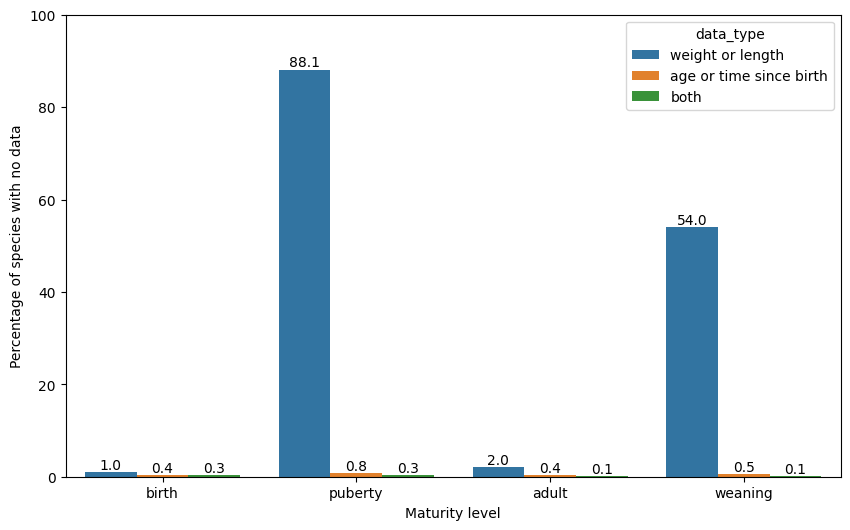

In [59]:
plot_missing_values_per_mat_level(raw_stx_data)

# Missing values in filled data 

In [19]:
filled_data = pd.read_csv('../data/interim/filled_data.csv', index_col=0)
filled_data

,p_Am,kap,v,p_M,E_G,h_a,E_Hb,E_Hj,E_Hx,E_Hp,...,Lp,Li,d_V,Ri,T_typical,t_0,model,metamorphosis,weaning,foetus
species,,,,,,,,,,,,,,,,,,,,,
Abatus_cordatus,41.918449,0.77712,0.027220,13.8449,2393.8237,5.047000e-06,0.487600,6.941000,NaN,1403.000,...,1.90,8.0,0.09,NaN,278.15,NaN,abj,True,False,False
Abbottina_rivularis,75.309251,0.97055,0.020221,23.8370,5215.8135,3.547000e-07,0.045900,0.069550,NaN,89.340,...,4.50,18.9,0.20,7.772727,291.15,149.8737,abj,True,False,False
Ablennes_hians,201.398502,0.99640,0.022797,17.9765,5237.1062,1.614000e-09,0.003540,0.029360,NaN,1083.000,...,47.40,140.0,0.20,73.373736,301.05,NaN,abj,True,False,False
Abra_segmentum,8.266674,0.93000,0.020926,25.2041,2349.9631,7.505000e-07,0.000601,0.011460,NaN,10.940,...,0.90,1.9,0.09,48.959720,288.15,NaN,abj,True,False,False
Abralia_trigonura,109.484284,0.98081,0.009515,1009.8108,5492.3580,1.526000e-10,0.001511,2.628000,NaN,14.090,...,1.40,4.0,0.21,NaN,291.15,NaN,abj,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zosterisessor_ophiocephalus,90.838193,0.97755,0.020245,17.1271,5231.3551,1.513000e-07,0.003958,NaN,NaN,1577.000,...,12.65,29.9,0.20,100.486494,290.25,NaN,std,False,False,False
Zosterops_lateralis,872.827510,0.97558,0.035919,617.3516,7324.4923,2.674000e-12,76.790000,NaN,456.8,1199.000,...,NaN,NaN,0.28,0.067583,314.75,NaN,std,False,False,False
Zosterops_virens,940.612495,0.99060,0.031028,734.2559,7319.8077,3.005000e-12,21.060000,NaN,101.4,294.800,...,NaN,NaN,0.28,0.045055,314.75,NaN,std,False,False,False


In [20]:
print_missing_values_per_column(filled_data)

58.8 % missing values in column E_Hj
75.7 % missing values in column E_Hx
0.0 % missing values in column climate
0.0 % missing values in column ecozone
0.0 % missing values in column habitat
0.0 % missing values in column embryo
66.3 % missing values in column migrate
0.0 % missing values in column food
0.0 % missing values in column gender
0.0 % missing values in column reprod
28.4 % missing values in column ab
98.4 % missing values in column ah
96.2 % missing values in column aj
91.3 % missing values in column ax
60.9 % missing values in column ap
1.1 % missing values in column am
84.1 % missing values in column tg
99.8 % missing values in column tb
95.9 % missing values in column tj
75.5 % missing values in column tx
43.5 % missing values in column tp
4.3 % missing values in column Wwb
93.5 % missing values in column Wwj
92.5 % missing values in column Wwx
47.1 % missing values in column Wwp
7.2 % missing values in column Wwi
73.5 % missing values in column Lb
93.5 % missing values 

C:\Users\diogo\AppData\Local\Temp\ipykernel_6272\2358594085.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filled_std_data = filled_data[raw_data['model'] == 'std'].copy()
C:\Users\diogo\AppData\Local\Temp\ipykernel_6272\2358594085.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filled_stx_data = filled_data[raw_data['model'] == 'stx'].copy()
C:\Users\diogo\AppData\Local\Temp\ipykernel_6272\2358594085.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filled_abj_data = filled_data[raw_data['model'] == 'abj'].copy()


Text(0.5, 1.0, 'abj')

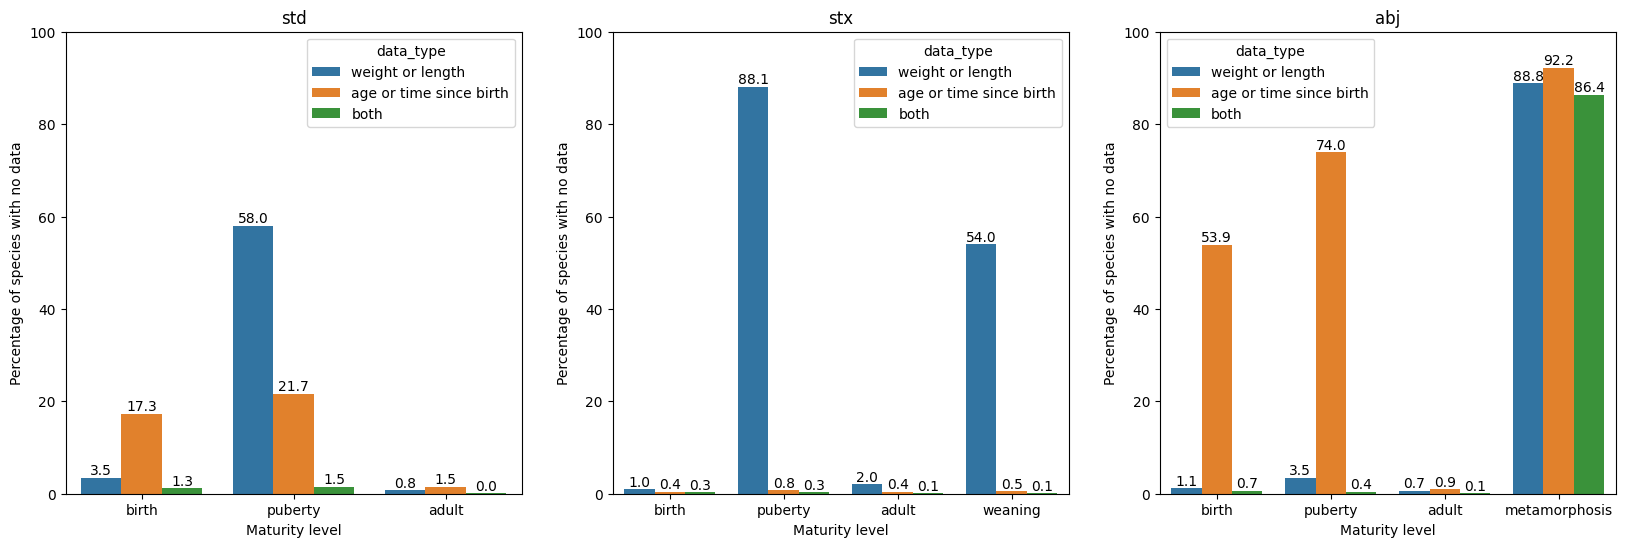

In [50]:
filled_std_data = filled_data[raw_data['model'] == 'std'].copy()
filled_stx_data = filled_data[raw_data['model'] == 'stx'].copy()
filled_abj_data = filled_data[raw_data['model'] == 'abj'].copy()
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
plot_missing_values_per_mat_level(filled_std_data, ax=axes[0])
axes[0].set_title('std')
plot_missing_values_per_mat_level(filled_stx_data, ax=axes[1])
axes[1].set_title('stx')
plot_missing_values_per_mat_level(filled_abj_data, ax=axes[2])
axes[2].set_title('abj')

## Number of samples depending on datasets used

In [30]:
bijection_datasets = ['ab', 'ax', 'aj', 'ap', 'am', 'd_V', 'Wwb', 'Wwx', 'Wwj', 'Wwp', 'Wwi', 'Ri']
print_missing_values_per_column(filled_data, columns=bijection_datasets)

28.4 % missing values in column ab
91.3 % missing values in column ax
96.2 % missing values in column aj
60.9 % missing values in column ap
1.1 % missing values in column am
4.3 % missing values in column Wwb
92.5 % missing values in column Wwx
93.5 % missing values in column Wwj
47.1 % missing values in column Wwp
7.2 % missing values in column Wwi
15.9 % missing values in column Ri


In [63]:
abj_columns = ['E_Hj', 'Wwj', 'aj']
stx_columns = ['E_Hx', 'Wwx', 'ax']
def drop_species_with_missing_values(df):

    # abj models
    subset = [col for col in df.columns if col not in stx_columns]
    print(len(subset), subset)
    abj_df = df[df['metamorphosis']].dropna(subset=subset)

    # stx models
    subset = [col for col in df.columns if col not in abj_columns]
    print(len(subset), subset)
    stx_df = df[df['weaning']].dropna(subset=subset)
    
    # std models
    subset = [col for col in df.columns if col not in abj_columns and col not in stx_columns]
    print(len(subset), subset)
    std_df = df[~df['weaning'] & ~df['metamorphosis']].dropna(subset=subset)
    
    filtered_df = pd.concat([abj_df, std_df, stx_df], axis=0)
    
    print('std', len(std_df), len(std_df)/len(filtered_df))
    print('stx', len(stx_df), len(stx_df)/len(filtered_df))
    print('abj', len(abj_df), len(abj_df)/len(filtered_df))
    
    return filtered_df

In [64]:
# Create a checkbox widget for each string in the list
checkboxes = [widgets.Checkbox(value=True, description=col) for col in bijection_datasets]

# Function to print the selected columns
def print_selected_columns(**kwargs):
    
    selected_columns = [col for col, selected in kwargs.items() if selected] + ['metamorphosis', 'weaning', 'foetus']
    sel_df = filled_data[selected_columns]
    sel_df = drop_species_with_missing_values(sel_df)
    print(len(sel_df))

# Create an interactive widget to monitor the checkbox selections
interactive_widget = widgets.interactive(print_selected_columns, **{col: checkbox for col, checkbox in zip(bijection_datasets, checkboxes)})

# Display the widgets
display(widgets.HBox(checkboxes), interactive_widget.children[-1])


Output()

## Number of samples depending on the datasets chosen for each maturity level

In [27]:
n_samples_df = pd.DataFrame(columns=['b', 'bjx', 'p', 'n_samples'], index=range(3*3*3))
base_cols = ['am', 'd_V', 'Wwi', 'Ri']
i = 0

def get_data_types(data_types):
    if len(data_types) == 2:
        return 'both'
    elif data_types[0][0] == 'a':
        return 'age'
    else:
        return 'weight'
    
"""for b_data in [['ab'], ['Wwb'], ['ab', 'Wwb']]:
    for bjx_data in [['abjx'], ['Wwbjx'], ['abjx', 'Wwbjx']]:
        for p_data in [['ap'], ['Wwp'], ['ap', 'Wwp']]:
            n_samples_df.loc[i, 'b'] = get_data_types(b_data)
            n_samples_df.loc[i, 'bjx'] = get_data_types(bjx_data)
            n_samples_df.loc[i, 'p'] = get_data_types(p_data)
            cols = base_cols + b_data + bjx_data + p_data
            n_samples_df.loc[i, 'n_samples'] = len(filled_data[cols].dropna(how='any', axis=0))
            i += 1"""
for b_data in [['ab'], ['Wwb'], ['ab', 'Wwb']]:
    for p_data in [['ap'], ['Wwp'], ['ap', 'Wwp']]:
        n_samples_df.loc[i, 'b'] = get_data_types(b_data)
        n_samples_df.loc[i, 'bjx'] = get_data_types(bjx_data)
        n_samples_df.loc[i, 'p'] = get_data_types(p_data)
        cols = base_cols + b_data + p_data
        n_samples_df.loc[i, 'n_samples'] = len(filled_data[cols].dropna(how='any', axis=0))
        i += 1

n_samples_df.sort_values(by='n_samples', ascending=False)           

,b,bjx,p,n_samples
4,weight,age,weight,1813
0,age,age,age,1605
3,weight,age,age,1592
6,both,age,age,1559
1,age,age,weight,1106
7,both,age,weight,1098
5,weight,age,both,485
2,age,age,both,478
8,both,age,both,470
9,NaN,NaN,NaN,NaN


## Taxonomy distribution

In [ ]:
sns.df['class'].value_counts()